        stty -F /dev/ttyACM* 57600 ixon
        sleep 4
        stty cols 53 rows 20
        price | tee /dev/ttyACM*

# ANSI serial terminal test

In [242]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from pylab import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
BAUDRATE = 57600
#BAUDRATE = 38400
#BAUDRATE = 9600
CW,CH = 6,12
TERMROWS = 20
TERMCOLS = 53

pauseaftershow = 5 #seconds

CONTROL            = '\x1b'
CSI                = CONTROL+'['
clearafter         = CSI + '0J'
clearbefore        = CSI + '1J'
clearscreen        = CSI + '2J'
clearscreen2       = CSI + '3J'
clearright         = CSI + '0K'
clearleft          = CSI + '1K'
clearline          = CSI + '2K'
underline          = CSI + '3m'
underline          = CSI + '4m'
double_underline_1 = CSI + '21m'
double_underline_2 = CSI + '61m'
overline_1         = CSI + '53m'
overline_2         = CSI + '62m'
double_overline    = CSI + '63m'
strike             = CSI + '9m'
verybold           = CSI + '20m'
vtab               = '\x0b'
upstart            = CSI+'F'
downstart          = CSI+'E'
savecursor         = '\x1b7'
restorecursor      = '\x1b8'
showcursor         = CSI+"?25h"
hidecursor         = CSI+"?25l"
reset              = '\x1bc'
getcursor          = CSI+'6n'

def scroll(n):
    return CSI+'%d'%abs(n)+('T' if n<0 else 'S')

def goto(r,c):
    return '\x1b[%d;%dH'%(r+1,c+1)

up    = lambda n: '\x1b[%dA'%n
down  = lambda n: '\x1b[%dB'%n
left  = lambda n: '\x1b[%dD'%n
right = lambda n: '\x1b[%dC'%n

def coljump(c):
    return CSI+'%d'%(c+1)+'G'

import os,serial,time,sty
from sty import fg, bg

ports = [f for f in os.listdir('/dev/') if 'acm' in f.lower() or 'ttyusb' in f.lower()]
print('Available ports:\n  '+'\n  '.join(ports))
port = '/dev/'+ports[0]
print('Using port',port)
arduino = serial.Serial(port=port, 
    baudrate=BAUDRATE, 
    xonxoff=False,  
    timeout=.1) 
    #write_timeout=5)

#os.system('stty -F %s %s ixon cr3 ff1 nl1 bs1'%(port,BAUDRATE))
time.sleep(3)

def print2(s='',delay=None):
    if delay == None: 
        delay=0
    throttle = delay*(len(s)/TERMCOLS+s.count('\n'))
    delay = throttle / len(s)
    if delay>0: print(1/delay*8)
    for b in s:
        arduino.write(b.encode('utf-8'))
        arduino.flush()
        time.sleep(delay)

def println2(s='',delay=None):
    print2(s+'\n',delay=delay)

import unicodedata

def exists(c):
    try: unicodedata.name(c)
    except: return False
    return True

def drain():
    while len(arduino.read()): pass

DEVICE_CONTROL4 = chr(20)
PRINT_SCREEN = DEVICE_CONTROL4

def unpack_RRRBBGGG(i):
    i = uint8(i)
    G = i&0b111
    B = (i>>3)&0b11
    R = (i>>5)&0b111
    B = (B*255)//3
    R = (R*255)//7
    G = (G*255)//7
    return (R,G,B)

def to_RGB(screen):
    RGB = [unpack_RRRBBGGG(i) for i in screen.ravel()]
    RGB = array(RGB).reshape((240,320,3))
    return RGB

def printscreen():
    # Drain buffer
    while len(arduino.read()): pass
    print2(PRINT_SCREEN)
    screendata = np.zeros((240,320))
    for y in range(320):
        for x in range(240):
            got = arduino.read()
            while len(got)==0:
                got = arduino.read()
            screendata[x,y] = ord(got)
        progress = int(round((x + y*240) / (320*240) * 40))
        bar = '['+'|'*progress + ' '*(41-progress)+']'
        print('\r' + bar, end='', flush = True)
    print('\r' + '(done)'.ljust(43), flush = True)
    return to_RGB(screendata)

def save_snapshot(filename):
    screen = printscreen()
    imh,imw = screen.shape[:2]
    figure(figsize=(imw,imh),dpi=1)
    imshow(screen,interpolation='nearest')
    axis('off')
    subplots_adjust(0,0,1,1,0,0)
    savefig(filename)

Available ports:
  ttyACM0
Using port /dev/ttyACM0


In [235]:
print2(reset + 'hi')

In [236]:
print2(sty.rs.all + clearscreen)
print2(goto(6,55//2-8)+fg(255,100,0)+'◖'+sty.ef.inverse+'Hello world!'+sty.rs.inverse+'◗')
print2(goto(8,55//2-12)+fg(255,100,0)+'◖'+sty.ef.inverse+'This is an Arduino TTY'+sty.rs.inverse+'◗')
print2(goto(10,0)+'Its running at a baud rate of %d, and expects utf-8 encoded text. ANSI styling commands are supported. The hardware is an Arduino UNO with an Adafruit-style ILI9341 LCD screen shield. '%BAUDRATE)

# Positioning, clearing, scrolling

In [237]:
ANIMATION_DELAY = 0.35

print2(sty.rs.all + clearscreen)

# Show/hide the cursor
println2(showcursor+"[?25h shows the cursor")
time.sleep(ANIMATION_DELAY)

println2(hidecursor+"[?25l hides it")
time.sleep(ANIMATION_DELAY)

println2(CSI+"?25hlet's show it for now")
time.sleep(ANIMATION_DELAY)

print2(bg(7) + clearscreen + 'clear screen ]2J gray')
time.sleep(ANIMATION_DELAY)

print2(bg.green + clearscreen2 + 'clear screen ]3J green')
time.sleep(ANIMATION_DELAY)

print2(goto(TERMROWS//2-1,TERMCOLS//2))
print2(bg.red  + clearbefore + '\r clear before ]1J red')
time.sleep(ANIMATION_DELAY)

print2(goto(TERMROWS//2-1,TERMCOLS//2))
print2(bg(5)+clearright+'     clear right ]0K mauve')
time.sleep(ANIMATION_DELAY)

print2(goto(TERMROWS//2,TERMCOLS//2))
print2(bg.blue + clearafter + '     clear after ]0J blue')
time.sleep(ANIMATION_DELAY)

print2(goto(TERMROWS//2,TERMCOLS//2))
print2(bg(6)+clearleft+'\r clear left   ]1K cyan')
time.sleep(ANIMATION_DELAY)

print2(bg(3))
print2(scroll(2)  + goto(0,0) + 'Scrolled up   2 [2S brown')
time.sleep(ANIMATION_DELAY)

print2(bg(2))
print2(scroll(-1) + goto(TERMROWS-2,0) + 'Scrolled down 1 [1T green')
time.sleep(ANIMATION_DELAY)



# Colors

In [238]:
offset = 1
s = sty.rs.all+clearscreen
s += goto(0,offset) + '16-color pallet:'
s += goto(1,offset)
for i in range(16):
    s += bg(i)+'  '
s += goto(2,offset) + bg(0) + '6x6x6 color cube:'
for r in range(6):
    s += goto(r+3,offset)
    for g in range(6):
        for b in range(6):
            s += bg(b+g*6+r*36+16)+' '
        s += bg(0)+' '
s += goto(9,offset)+"Grays (can\'t render all with 8-bit RRRBBGGG color)"
s += goto(10,offset)
for q in range(24):
    s+=bg(q+232)+' '
s += goto(11,offset)+sty.rs.all
s += '[*;2;R;G;Bm color codes\n '
for g in range(8):
    for r in range(8):
        for b in range(4):
            s += bg(round(r*255/7),round(g*255/7),round(b*255/3))+' '
    s += goto(13+g,offset)
xoffset = 53-8*2-1
s += goto(10,xoffset+3)+sty.rs.all+'Colors 0-7'
s += goto(11,xoffset)
s += 'Fore/background'
for j in range(8):
    s += goto(12+j,xoffset)
    s += bg(j)
    for i in range(8):
        s += fg(i+8)
        s += '%d%d'%(i,j)
print2(s,delay=0);


## Control / navigation 

In [239]:
print2(sty.rs.all + clearscreen)
time.sleep(ANIMATION_DELAY)
println2('(cursor starts at 0,0)')
time.sleep(ANIMATION_DELAY)
print2('(Save it with control+7)'+bg.red+' '+sty.rs.all+savecursor)
time.sleep(ANIMATION_DELAY)
print2(goto(2,4)+'(... then move somewhere)')
time.sleep(ANIMATION_DELAY)
print2(restorecursor + '(Then return via control+8)')
time.sleep(ANIMATION_DELAY)
print2(goto(3,0))
time.sleep(ANIMATION_DELAY)
print2('carriage return... we\'ll overwrite this in a second')
time.sleep(ANIMATION_DELAY)
println2('\r'+'carr. rtn.: (done)')
time.sleep(ANIMATION_DELAY)
println2('bell  "\\a": \a(did the screen flash?)')
time.sleep(ANIMATION_DELAY)
print2('bksp  "\\b": we\'ll delete this in a second')
time.sleep(ANIMATION_DELAY)
println2('\b'*len("we\'ll delete this in a second") + '(deleted)')
time.sleep(ANIMATION_DELAY)
println2('tab   "\\t": tab\ttab')
time.sleep(ANIMATION_DELAY)
println2('ffeed   12: B\fB')
time.sleep(ANIMATION_DELAY)
println2('vtab    11: A'+vtab+'Hi.')
time.sleep(ANIMATION_DELAY)
print2('navigation test -----  +'+
       left(2)+'L'+
       up(1)  +'U'+
       left(1)+down(2)+'D'+
       left(1)+up(1)+right(1)+'R',delay=1)
time.sleep(ANIMATION_DELAY)
print2(down(3)+downstart+'(down to start of line) ]E')
time.sleep(ANIMATION_DELAY)
print2(upstart+'(up   to start of line) ]F')
time.sleep(ANIMATION_DELAY)
print2(down(1)+downstart+':'+coljump(TERMCOLS//2)+'<- Jump to column')
time.sleep(ANIMATION_DELAY)


# We can also request the cursor position
print2(getcursor)
print((b''.join([arduino.read() for i in range(10)])))


424.0
b'\x1b[000;043R'


## Text effects

In [240]:
def ul(*args):
    # Set underlying color
    if len(args)==1 and args[0]<8:
        return '\x1b[%dm'%(100+args[0])
    return bg(*args).replace('[48','[58')
sty.ul = ul

color = fg(255,255,255)
fonttest = 'AaBbCcDdEeFfGg1234567890' + sty.rs.all
underline          = '\x1b[3m'
underline          = '\x1b[4m'
double_underline_1 = '\x1b[21m'
double_underline_2 = '\x1b[61m'
overline_1         = '\x1b[53m'
overline_2         = '\x1b[62m'
double_overline    = '\x1b[63m'
strike             = '\x1b[9m'
verybold           = '\x1b[20m'

s = clearscreen + sty.rs.all+fg.white+bg.black 
s += 'Fancy font effects:\n\n'
s += 'Bold    [1: '+sty.ef.bold+fonttest+ '\n'
s += 'Faint   [2: '+sty.ef.dim+fonttest+ '\n'
s += 'Italic  [3: '+sty.ef.italic+fonttest+ '\n'
s += 'Bld+It    : '+sty.ef.bold+sty.ef.italic+fonttest+ '\n'
s += 'Blink   [5: '+sty.ef.blink+fonttest+ '\n'
s += 'BBold  [20: '+verybold+fonttest+ '\n'
s += 'B+BBld    : '+sty.ef.bold+verybold+fonttest+ '\n'
s += 'Invert  [7: '+sty.ef.inverse+fonttest+ '\n'
s += '1xOver [53: '+ul(1)+overline_1+fonttest+ '\n'
s += '1xOver [62: '+ul(1)+overline_2+fonttest+ '\n'
s += '2xOver [63: '+ul(1)+double_overline+fonttest+ '\n'
s += '1xUnder [4: '+ul(1)+underline+fonttest+ '\n'
s += '2xUnder[21: '+ul(1)+double_underline_1+fonttest+ '\n'
s += '2xUnder[61: '+ul(1)+double_underline_2+fonttest+ '\n'
s += 'Strike  [9: '+ul(1)+strike+fonttest+ '\n'
s += '2xO 2xU S : '+ul(1)+double_underline_1+double_overline+strike+fonttest+ '\n'

print2(s,delay=0.005)


39503.69540873461


# Unicode

In [241]:
print2(clearscreen + sty.rs.all+fg.white+bg.black)

s = 'Braille patterns:\n\n'
for i in range(0x2800,0x28FF+1):
    s += chr(i)
    
s += '\n\nBlock sextants:\n\n'
for i in range(0x1FB00,0x1fb3b+1):
    s+=chr(i)
    
s += '\n\nTeletext:\n\n'
s += ''.join([chr(i) for i in range(0x1FB3C,0x1FB3C+44)])
    
print2(s)
time.sleep(pauseaftershow)
#save_snapshot('teletext')

(done)                                     


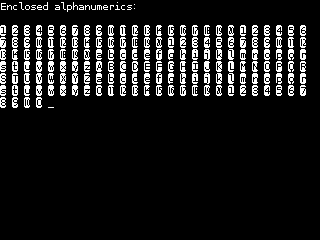

In [250]:
print2(reset + sty.rs.all+fg.white+bg.black)
s = 'Enclosed alphanumerics:\n\n'
for i in range(0x2460,1+0x24FF):
    s += chr(i)+' '
    if ((i-0x2460)%26==25): s+='\n'
print2(s)
#save_snapshot('enclosed')

(done)                                     


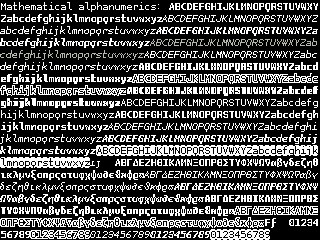

In [251]:
print2(reset + sty.rs.all+fg.white+bg.black)
s = 'Mathematical alphanumerics: '
for i in range(ord('𝐀'),1+0x1D7FF):
    s += chr(i)
print2(s)
#save_snapshot('mathematical')

(done)                                     


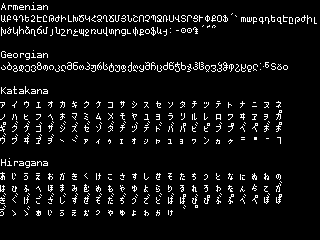

In [252]:
s = reset

s  += 'Armenian\n'
for i in range(0x00000530,1+0x0000058F):
    c = chr(i)
    if exists(c) and not c in 'ՙ՟՛՜՞': s += chr(i)
s += ' ՛ ՜ ՞'

s += '\n\nGeorgian\n'
for i in range(0x000010A0,1+0x000010FF):
    if i<ord('ა'): continue
    c = chr(i)
    if exists(c): 
        s += c

s += '\n\nKatakana\n'
for j,c in enumerate('アイウエオカキクケコサシスセソタチツテトナニヌネノハヒフヘホマミムメ'
                     'モヤユヨラリルレロワヰヱヲガギグゲゴザジズゼゾダヂヅデドバパビピブプ'
                     'ベペボポヴヷヸヹヺヽヾァィゥェォッャュョヮンヵヶ゠・ーヿ'):
#for j,i in enumerate(range(0x30A0,1+0x30FF)):
    #c = chr(i)
    if exists(c): s += c+' '
    if j%24==23: s += '\n'
s += '\nHiragana\n'
for j,c in enumerate('あいうえおかきくけこさすしせそたちつとなにぬねのはひふへほ'
                     'まみむめもやゆよらりるれろわをんゟてがぎぐげござじずぜぞだ'
                     'ぢづでどばぱびぴぶぷべぺぼぽゔゝゞぁぃぅぇぉっゃゅょゎゕゖ゛゜'):
    if exists(c) and not c in 'ゐゑ\u3099\u309A': s += c+' '
    if j%24==23: s += '\n'

print2(s)
#save_snapshot('extras')

(done)                                     


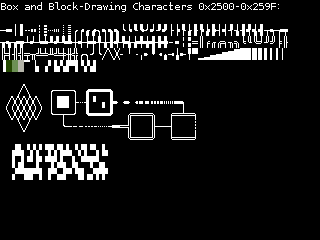

In [253]:
s=reset+hidecursor
s+='Box and Block-Drawing Characters 0x2500-0x259F:\n\n'
#"""
s+='─━│┃┄┅┆┇┈┉┊┋┌┍┎┏┐┑┒┓└┕┖┗┘┙┚┛├┝┞┟┠┡┢┣┤┥┦┧┨┩┪┫┬┭┮┯\n'
s+='┰┱┲┳┴┵┶┷┸┹┺┻┼┽┾┿╀╁╂╃╄╅╆╇╈╉╊╋╌╍╎╏═║╒╓╔╕╖╗╘╙╚╛╜╝╞╟\n'
s+='╠╡╢╣╤╥╦╧╨╩╪╫╬╭╮╯╰╱╲╳╴╵╶╷╸╹╺╻╼╽╾╿▀▁▂▃▄▅▆▇█▉▊▋▌▍▎▏\n'
s+='▐░▒▓▔▕▖▗▘▙▚▛▜▝▞▟\n\n'

#"""
s+='   ╱╲   ┌───┐ ┏━━━┓\n'
s+=' ╱╳╳╳╳╲ │▐█▌├┈┨▝ ▖┣╸╺╸╺╍╍┅┅┉┉━┑\n'
s+=' ╲╳╳╳╳╱ └─┬─┘ ┗━━━┛  ╔═══╗  ╒═╧═╕\n'
s+='   ╲╱     ╰─╌╌┄┄┈┈╼━═╣   ╟──┤   ┆\n'
s+='                     ╚═══╝  ╘═══╛\n'
s+='  ▟▙▝▞▞▝▛▞▙▙▝▞▌▀▖▙\n'
s+='  ▌▟▝▘▛▝▜▚▙ ▙▝▀▛▚▖\n'
s+='  ▞▀█▛▜ ▛▚▟▀▝█▗▞▛▛\n'

print2(s)
time.sleep(pauseaftershow)
#save_snapshot('semigraphics')

```
!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}¡¢£
¤¥¦§¨©ª«¬®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿĀāĂăĄ
ąĆćĈĉĊċČčĎďĐđĒēĔĕĖėĘęĚěĜĝĞğĠġĢģĤĥĦħĨĩĪīĬĭĮįİıĲĳĴĵĶķĸĹĺĻļĽľĿŀŁłŃńŅņŇňŉŊŋŌōŎŏŐőŒœŔŕŖŗŘřŚśŜŝŞşŠšŢţŤ
ťŦŧŨũŪūŬŭŮůŰűŲųŴŵŶŷŸŹźŻżŽžſƀƁƂƄƅƆƇƉƊƋƍƎƏƐƒƓƔƖƗƘƚƞƟƤƦƧƨƩƫƱƵƶƷƸƹƻƼƿǀǁǂǃǄǅǆǇǈǉǊǋǌǍǎǏǐǑǒǓǔǝǢǣǦǧǨǩǪǫǮ
ǯǰǱǲǳǴǸǹǼǽȀȁȂȃȄȅȆȇȈȉȊȋȌȍȎȏȐȑȒȓȔȕȖȗȘșȚțȜȝȞȟȠȢȣȤȥȦȧȨȩȮȯȲȳȷȸȹȺȻȼȽȾɁɄɅɆɇɈɉɌɍɎɏɑɒɔɘəɛɜɟɢɣɨɩɪɯɰɱɴɵɸʀʁʋ
ʍʏʒʔʘʙʜʟʹʻʼˆˇˈˉˊˋː˗˘˙˚˛˜˝˴˸ ̀ ́ ̂ ̃ ̄ ̅ ̆ ̇ ̈ ̉ ̊ ̋ ̌ ̍ ̎ ̏ ̐ ̑ ̒ ̓ ̔ ̕ ̖ ̗ ̘ ̙ ̚ ̛ ̜ ̝ ̞ ̟ ̠ ̡ ̢ ̣ ̤ ̥ ̦ ̧ ̨ ̩ ̪ ̫ ̬ ̭ ̮ ̯ ̰ ̱ ̲ ̳ ̴ ̵ ̶ ̷ ̸ ̹ ̻ ̼ ̽ ̾ ̿ ̀ ́ ͂ ̈́ ͅ ͆
 ͇ ͈ ͉ ͊ ͋ ͌ ͍ ͎ ͐ ͑ ͒ ͓ ͔ ͕ ͖ ͗ ͘ ͙ ͚ ͛ͰͱͲͳʹ͵Ͷͷͺͻͼ;Ϳ΄΅Ά·ΈΉΊΌΎΏΐΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩΪΫάέήίΰαβγδεζηθικλμνξοπρςστυ
φχψωϊϋόύώϏϐϑϒϓϔϕϖϗϘϙϚϛϜϝϞϟϠϡϢϣϤϥϦϧϨϩϬϭϮϯϰϱϲϳϴϵ϶ϷϸϹϺϻϽϾЀЁЂЃЄЅІЇЈЉЊЋЌЍЎЏАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩ
ЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяѐёђѓєѕіїјљњћќѝўџѠѡѢѣѤѥѦѧѨѩѪѫѬѭѮѯѰѱѲѳѴѵѶѷѸѹѺѻѼѽѾѿҁ҂ҌҍҐґҒҔҕҖ
җҘҚқҞҟҢңҨҩҪҫҬҭҮҰҲҳҶҷҺһҽӀӁӂӃӄӅӆӇӈӉӊӋӌӍӎӏӐӑӒӓӔӕӖӗӘәӚӜӝӞӠӡӢӣӤӥӦӧӨөӪӮӯӰӱӲӳӴӵӶӷӸӹӼӽԀԁԌԍԐԑԚԛԜԝԤԥԦԧԮԯԱԲ
ԳԴԵԶԷԸԹԺԻԼԽԾԿՀՁՂՃՄՅՆՇՈՉՊՋՌՍՎՏՐՑՒՓՔՕՖՙ՚՛՝՞ՠաբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքօֆևֈ։֊֍֎֏ ऀ ँ ं ःऄअआइई
उऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसह ऺ ऻ ़ऽ ा ु ू ृ ॄ ॅ ॆ े ै ॉ ॊ ो ौ ्ॐ ॑ ॒ ॓ ॔ ॕ ॖ ॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡ ॢ।॥०१२३४५६७
८९॰ॱॹॺॻॼॽॾॿႹႽჍაბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰჱჲჳჴჵჶჷჸჹჺ჻ჼჽჾჿḂḃḄḅḆḇḊḋḌḍḎḏḐḑḒḓḘḙḚḛḞḟḠḡḢḣḤḥḦḧḨḩḪḫ
ḬḭḰḱḲḳḴḵḶḷḺḻḼḽḾḿṀṁṂṃṄṅṆṇṈṉṊṋṔṕṖṗṘṙṚṛṞṟṠṡṢṣṪṫṬṭṮṯṰṱṲṳṴṵṶṷṼṽṾṿẀẁẂẃẄẅẆẇẈẉẊẋẌẍẎẏẐẑẒẓẔẕẖẗẘẙẚẛẜẞẟẠạẢảẸ
ẹẺẻẼẽỈỉỊịỌọỎỏỤụỦủỲỳỴỵỶỷỸỹỼỽỿ᾽ι᾿´῾‐‑‒–—―‖‘’‚“”„‟†‡•․…‧‰‱′‵‹›‼‽⁋⁚⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎₧₩₪€
₮₰₳₸₹₺₽₾₿ℂ℃℅℆ℇ℈℉ℊℋℌℍℎℏℐℑℒℓℕ№ℙℚℛℜℝ℞™ℤΩ℧ℨKÅℬℭ℮ℯℰℱℲℳℴℵℹℽℾℿ⅀⅁⅂⅃⅄ⅅⅆⅇⅈⅉ⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟ⅠⅡⅢⅣⅤⅥⅨⅩⅪⅬⅭⅮⅯⅰⅱ
ⅲⅳⅴⅵⅸⅹⅺⅼⅽⅾⅿↀↁↃↄↅↆↇ↉↊↋←↑→↓↔↕↖↗↘↙↞↟↠↡↨↯↰↱↲↳↴↵↶↷↹↺↻↼↽↾↿⇀⇁⇂⇃⇄⇐⇒⇕⇠⇡⇢⇣⇧⇨⇳⇽⇾∀∁∂∃∅∆∇∈∊∍∎∏∑−∓∕∖∗∘∙√∞∟∣∥∨∩
∪∫∬∶≈≠≡≤≥⊙⊤⊥⊳⋁⋂⋃⋄⋅⋿⌐⌠⌡⍳⍴⍵⍶⍷⍸⍹⍺①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽⑾⑿⒀⒁⒂⒃⒄⒅⒆⒇⒈⒉⒊⒋⒌⒍⒎⒏⒐⒑⒒⒓⒔⒕⒖⒗⒘⒙⒚⒛⒜⒝⒞⒟⒠⒡
⒢⒣⒤⒥⒦⒧⒨⒩⒪⒫⒬⒭⒮⒯⒰⒱⒲⒳⒴⒵ⒶⒷⒸⒹⒺⒻⒼⒽⒾⒿⓀⓁⓂⓃⓄⓅⓆⓇⓈⓉⓊⓋⓌⓍⓎⓏⓐⓑⓒⓓⓔⓕⓖⓗⓘⓙⓚⓛⓜⓝⓞⓟⓠⓡⓢⓣⓤⓥⓦⓧⓨⓩ⓪⓫⓬⓭⓮⓯⓰⓱⓲⓳⓴⓵⓶⓷⓸⓹⓺⓻⓼⓽⓾⓿─━
│┃┄┅┆┇┈┉┊┋┌┍┎┏┐┑┒┓└┕┖┗┘┙┚┛├┝┞┟┠┡┢┣┤┥┦┧┨┩┪┫┬┭┮┯┰┱┲┳┴┵┶┷┸┹┺┻┼┽┾┿╀╁╂╃╄╅╆╇╈╉╊╋╌╍╎╏═║╒╓╔╕╖╗╘╙╚╛╜╝╞╟╠╡
╢╣╤╥╦╧╨╩╪╫╬╭╮╯╰╱╲╳╴╵╶╷╸╹╺╻╼╽╾╿▀▁▂▃▄▅▆▇█▉▊▋▌▍▎▏▐░▒▓▔▕▖▗▘▙▚▛▜▝▞▟■□▬▲△▴▵▶▷▹►▻▼▽▾▿◀◄◆◇◈◊○◌◎◐◑◒◓◔◕◖◗◘
◙◢◣◤◥◦◯◴◵◶◷◻◼◽◾★☉☐☑☒☥☦☧☨☩☺☻☼♀♂♠♡♢♣♤♥♦♧♩♪♫♬♰♱⚆⚇⚈⚉⚠⚪⚫⚬⛛⛤⛥⛦✀✁✂✃✄✅✓✔✕✖✗✘✙✚✛✜✝✞✟✠✡✢✣✤✥✦✧✨✩✪✫✬✭✮✯✰✱✲✳✴
✵✶✷✸✹✺✻✼✽✾✿❀❁❂❃❄❅❆❇❈❉❊❋❌❍❎❓❔❕❖❗❘❙❛❜❝❞❟❠❡❢❣❤❥❦❧❨❪❬❮❰❲❴❶❷❸❹❺❻❼❽❾❿➀➁➂➃➄➅➆➇➈➉➊➋➌➍➎➏➐➑➒➓➔➕➖➗➛➜➡➢➣➤➲⠁⠂
⠃⠄⠅⠆⠇⠈⠉⠊⠋⠌⠍⠎⠏⠐⠑⠒⠓⠔⠕⠖⠗⠘⠙⠚⠛⠜⠝⠞⠟⠠⠡⠢⠣⠤⠥⠦⠧⠨⠩⠪⠫⠬⠭⠮⠯⠰⠱⠲⠳⠴⠵⠶⠷⠸⠹⠺⠻⠼⠽⠾⠿⡀⡁⡂⡃⡄⡅⡆⡇⡈⡉⡊⡋⡌⡍⡎⡏⡐⡑⡒⡓⡔⡕⡖⡗⡘⡙⡚⡛⡜⡝⡞⡟⡠⡡⡢
⡣⡤⡥⡦⡧⡨⡩⡪⡫⡬⡭⡮⡯⡰⡱⡲⡳⡴⡵⡶⡷⡸⡹⡺⡻⡼⡽⡾⡿⢀⢁⢂⢃⢄⢅⢆⢇⢈⢉⢊⢋⢌⢍⢎⢏⢐⢑⢒⢓⢔⢕⢖⢗⢘⢙⢚⢛⢜⢝⢞⢟⢠⢡⢢⢣⢤⢥⢦⢧⢨⢩⢪⢫⢬⢭⢮⢯⢰⢱⢲⢳⢴⢵⢶⢷⢸⢹⢺⢻⢼⢽⢾⢿⣀⣁⣂
⣃⣄⣅⣆⣇⣈⣉⣊⣋⣌⣍⣎⣏⣐⣑⣒⣓⣔⣕⣖⣗⣘⣙⣚⣛⣜⣝⣞⣟⣠⣡⣢⣣⣤⣥⣦⣧⣨⣩⣪⣫⣬⣭⣮⣯⣰⣱⣲⣳⣴⣵⣶⣷⣸⣹⣺⣻⣼⣽⣾⣿⤌⤍⤎⤏⤐⤑⤫⤬⥀⥁⥊⥋⥌⥍⬁⬄⬆⬉⬌⬍⬤⬥⬦⬩⬷⬸⭠⭡⭢⭣⭪⭫⭬⭭⮉
⮊⮋⮘⮙⮚⮛⮜⮝⮞⮟⯁⯅⯆⯇⯈⯬⯭⯮⯯ⱣⱧⱨⱩⱪⱫⱬⱮⱯⱲⱵⱶぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめ
もゃやゅゆょよらりるれろゎわをんゔゕゖ ゙ ゚゛゜ゝゞゟ゠ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュ
ユョヨラリルレロヮワヰヱヲンヴヵヶヷヸヹヺ・ーヽヾヿㇲㇳㇴㇵㇶꓐꓑꓒꓓꓔꓕꓖꓗꓘꓙꓚꓛꓜꓝꓞꓟꓠꓡꓢꓣꓤꓥꓦꓧꓨꓩꓪꓫꓬꓭꓮꓯꓰꓱꓲꓳꓴꓵꓶꓷꓸꓹꓼꓽ꓿ꙄꙅꙇꙊꙋꙌꙍꙖꙗꙜꙞꙨꙩꙪꙫꙬꙭꙮ꙾Ꚁ
ꚁꚂꚃꚖꚗꜦꜧꜩꜫꜱꝀꝁꝂꝃꝈꝉꝊꝋꝎꝏꝮꝯꝰꝸꞀꞃꞅꞈ꞉꞊ꞋꞌꞍꞏꞐꞑꞔꞕꞘꞟꞫꞰꞱꞲꞳꞴꞵꞶꞷꟄꟆꟺꟻꟼꟽꬲꬽꭎꭒꭚﬀﬁﬂﬃﬄﬅﬆ𝐀𝐁𝐂𝐃𝐄𝐅𝐆𝐇𝐈𝐉𝐊𝐋𝐌𝐍𝐎𝐏𝐐𝐑𝐒𝐓𝐔𝐕𝐖𝐗𝐘𝐙𝐚𝐛𝐜
𝐝𝐞𝐟𝐠𝐡𝐢𝐣𝐤𝐥𝐦𝐧𝐨𝐩𝐪𝐫𝐬𝐭𝐮𝐯𝐰𝐱𝐲𝐳𝐴𝐵𝐶𝐷𝐸𝐹𝐺𝐻𝐼𝐽𝐾𝐿𝑀𝑁𝑂𝑃𝑄𝑅𝑆𝑇𝑈𝑉𝑊𝑋𝑌𝑍𝑎𝑏𝑐𝑑𝑒𝑓𝑔𝑕𝑖𝑗𝑘𝑙𝑚𝑛𝑜𝑝𝑞𝑟𝑠𝑡𝑢𝑣𝑤𝑥𝑦𝑧𝑨𝑩𝑪𝑫𝑬𝑭𝑮𝑯𝑰𝑱𝑲𝑳𝑴𝑵𝑶𝑷𝑸𝑹𝑺𝑻𝑼
𝑽𝑾𝑿𝒀𝒁𝒂𝒃𝒄𝒅𝒆𝒇𝒈𝒉𝒊𝒋𝒌𝒍𝒎𝒏𝒐𝒑𝒒𝒓𝒔𝒕𝒖𝒗𝒘𝒙𝒚𝒛𝒜𝒝𝒞𝒟𝒠𝒡𝒢𝒣𝒤𝒥𝒦𝒧𝒨𝒩𝒪𝒫𝒬𝒭𝒮𝒯𝒰𝒱𝒲𝒳𝒴𝒵𝒶𝒷𝒸𝒹𝒺𝒻𝒼𝒽𝒾𝒿𝓀𝓁𝓂𝓃𝓄𝓅𝓆𝓇𝓈𝓉𝓊𝓋𝓌𝓍𝓎𝓏𝓐𝓑𝓒𝓓𝓔𝓕𝓖𝓗𝓘𝓙𝓚𝓛𝓜
𝓝𝓞𝓟𝓠𝓡𝓢𝓣𝓤𝓥𝓦𝓧𝓨𝓩𝓪𝓫𝓬𝓭𝓮𝓯𝓰𝓱𝓲𝓳𝓴𝓵𝓶𝓷𝓸𝓹𝓺𝓻𝓼𝓽𝓾𝓿𝔀𝔁𝔂𝔃𝔄𝔅𝔆𝔇𝔈𝔉𝔊𝔋𝔌𝔍𝔎𝔏𝔐𝔑𝔒𝔓𝔔𝔕𝔖𝔗𝔘𝔙𝔚𝔛𝔜𝔝𝔞𝔟𝔠𝔡𝔢𝔣𝔤𝔥𝔦𝔧𝔨𝔩𝔪𝔫𝔬𝔭𝔮𝔯𝔰𝔱𝔲𝔳𝔴𝔵𝔶𝔷𝔸𝔹𝔺𝔻𝔼
𝔽𝔾𝔿𝕀𝕁𝕂𝕃𝕄𝕅𝕆𝕇𝕈𝕉𝕊𝕋𝕌𝕍𝕎𝕏𝕐𝕑𝕒𝕓𝕔𝕕𝕖𝕗𝕘𝕙𝕚𝕛𝕜𝕝𝕞𝕟𝕠𝕡𝕢𝕣𝕤𝕥𝕦𝕧𝕨𝕩𝕪𝕫𝕬𝕭𝕮𝕯𝕰𝕱𝕲𝕳𝕴𝕵𝕶𝕷𝕸𝕹𝕺𝕻𝕼𝕽𝕾𝕿𝖀𝖁𝖂𝖃𝖄𝖅𝖆𝖇𝖈𝖉𝖊𝖋𝖌𝖍𝖎𝖏𝖐𝖑𝖒𝖓𝖔𝖕𝖖𝖗𝖘𝖙𝖚𝖛𝖜
𝖝𝖞𝖟𝖠𝖡𝖢𝖣𝖤𝖥𝖦𝖧𝖨𝖩𝖪𝖫𝖬𝖭𝖮𝖯𝖰𝖱𝖲𝖳𝖴𝖵𝖶𝖷𝖸𝖹𝖺𝖻𝖼𝖽𝖾𝖿𝗀𝗁𝗂𝗃𝗄𝗅𝗆𝗇𝗈𝗉𝗊𝗋𝗌𝗍𝗎𝗏𝗐𝗑𝗒𝗓𝗔𝗕𝗖𝗗𝗘𝗙𝗚𝗛𝗜𝗝𝗞𝗟𝗠𝗡𝗢𝗣𝗤𝗥𝗦𝗧𝗨𝗩𝗪𝗫𝗬𝗭𝗮𝗯𝗰𝗱𝗲𝗳𝗴𝗵𝗶𝗷𝗸𝗹𝗺𝗻𝗼
𝗽𝗾𝗿𝘀𝘁𝘂𝘃𝘄𝘅𝘆𝘇𝘈𝘉𝘊𝘋𝘌𝘍𝘎𝘏𝘐𝘑𝘒𝘓𝘔𝘕𝘖𝘗𝘘𝘙𝘚𝘛𝘜𝘝𝘞𝘟𝘠𝘡𝘢𝘣𝘤𝘥𝘦𝘧𝘨𝘩𝘪𝘫𝘬𝘭𝘮𝘯𝘰𝘱𝘲𝘳𝘴𝘵𝘶𝘷𝘸𝘹𝘺𝘻𝘼𝘽𝘾𝘿𝙀𝙁𝙂𝙃𝙄𝙅𝙆𝙇𝙈𝙉𝙊𝙋𝙌𝙍𝙎𝙏𝙐𝙑𝙒𝙓𝙔𝙕𝙖𝙗𝙘𝙙𝙚𝙛𝙜
𝙝𝙞𝙟𝙠𝙡𝙢𝙣𝙤𝙥𝙦𝙧𝙨𝙩𝙪𝙫𝙬𝙭𝙮𝙯𝙰𝙱𝙲𝙳𝙴𝙵𝙶𝙷𝙸𝙹𝙺𝙻𝙼𝙽𝙾𝙿𝚀𝚁𝚂𝚃𝚄𝚅𝚆𝚇𝚈𝚉𝚊𝚋𝚌𝚍𝚎𝚏𝚐𝚑𝚒𝚓𝚔𝚕𝚖𝚗𝚘𝚙𝚚𝚛𝚜𝚝𝚞𝚟𝚠𝚡𝚢𝚣𝚤𝚥𝚨𝚩𝚪𝚫𝚬𝚭𝚮𝚯𝚰𝚱𝚲𝚳𝚴𝚵𝚶𝚷𝚸𝚹𝚺𝚻𝚼𝚽𝚾
𝚿𝛀𝛁𝛂𝛃𝛄𝛅𝛆𝛇𝛈𝛉𝛊𝛋𝛌𝛍𝛎𝛏𝛐𝛑𝛒𝛓𝛔𝛕𝛖𝛗𝛘𝛙𝛚𝛛𝛜𝛝𝛞𝛟𝛠𝛡𝛢𝛣𝛤𝛥𝛦𝛧𝛨𝛩𝛪𝛫𝛬𝛭𝛮𝛯𝛰𝛱𝛲𝛳𝛴𝛵𝛶𝛷𝛸𝛹𝛺𝛻𝛼𝛽𝛾𝛿𝜀𝜁𝜂𝜃𝜄𝜅𝜆𝜇𝜈𝜉𝜊𝜋𝜌𝜍𝜎𝜏𝜐𝜑𝜒𝜓𝜔𝜕𝜖𝜗𝜘𝜙𝜚𝜛𝜜𝜝𝜞
𝜟𝜠𝜡𝜢𝜣𝜤𝜥𝜦𝜧𝜨𝜩𝜪𝜫𝜬𝜭𝜮𝜯𝜰𝜱𝜲𝜳𝜴𝜵𝜶𝜷𝜸𝜹𝜺𝜻𝜼𝜽𝜾𝜿𝝀𝝁𝝂𝝃𝝄𝝅𝝆𝝇𝝈𝝉𝝊𝝋𝝌𝝍𝝎𝝏𝝐𝝑𝝒𝝓𝝔𝝕𝝖𝝗𝝘𝝙𝝚𝝛𝝜𝝝𝝞𝝟𝝠𝝡𝝢𝝣𝝤𝝥𝝦𝝧𝝨𝝩𝝪𝝫𝝬𝝭𝝮𝝯𝝰𝝱𝝲𝝳𝝴𝝵𝝶𝝷𝝸𝝹𝝺𝝻𝝼𝝽𝝾
𝝿𝞀𝞁𝞂𝞃𝞄𝞅𝞆𝞇𝞈𝞉𝞊𝞋𝞌𝞍𝞎𝞏𝞐𝞑𝞒𝞓𝞔𝞕𝞖𝞗𝞘𝞙𝞚𝞛𝞜𝞝𝞞𝞟𝞠𝞡𝞢𝞣𝞤𝞥𝞦𝞧𝞨𝞩𝞪𝞫𝞬𝞭𝞮𝞯𝞰𝞱𝞲𝞳𝞴𝞵𝞶𝞷𝞸𝞹𝞺𝞻𝞼𝞽𝞾𝞿𝟀𝟁𝟂𝟃𝟄𝟅𝟆𝟇𝟈𝟉𝟊𝟋𝟎𝟏𝟐𝟑𝟒𝟓𝟔𝟕𝟖𝟗𝟘𝟙𝟚𝟛𝟜𝟝𝟞𝟟𝟠
𝟡𝟢𝟣𝟤𝟥𝟦𝟧𝟨𝟩𝟪𝟫𝟬𝟭𝟮𝟯𝟰𝟱𝟲𝟳𝟴𝟵𝟶𝟷𝟸𝟹𝟺𝟻𝟼𝟽𝟾𝟿🎔🎜🎝🎧🏵🏶👆👇👈👉👍👎👻👾💀💉💎💓💔💕💖💗💘💙💚💛💜💝💞💟💠💲💴💹💽💾💿📀📇📞🔆🔇🔈🔉🔊🔛🔜🔝🔴🔵🔶🔷🔸🔹🔺🔻🔼🔾🔿🕀🕁🕂🕆🕇🕈
🕨🕩🕪🕻🕼🕽🕾🕿🖀🖁🖒🖓🖗🖘🖙🖚🖛🖜🖝🖞🖟🖠🖡🖢🖣🖤🖪🖫🖬🗅🗆🗇🗈🗉🗊🗋🗌🗍🗎🗏🗐🗑🗒🗴🗵🗶🗹🠅🠆🠉🠊🠔🠕🠖🠗🠙🠚🠝🠞🠤🠥🠦🠧🠩🠪🠭🠮🠱🠲🠸🠹🠺🠻🠽🠿🡀🡁🡂🡃🡄🡅🡆🡇🡐🡑🡒🡓🡔🡕🡖🡗🡘🡙🡨🡬🡭
🡮🡯🡶🡾🢆🢐🢑🢒🢓🬀🬁🬂🬃🬄🬅🬆🬇🬈🬉🬊🬋🬌🬍🬎🬏🬐🬑🬒🬓🬔🬕🬖🬗🬘🬙🬚🬛🬜🬝🬞🬟🬠🬡🬢🬣🬤🬥🬦🬧🬨🬩🬪🬫🬬🬭🬮🬯🬰🬱🬲🬳🬴🬵🬶🬷🬸🬹🬺🬻🬼🬽🬾🬿🭀🭁🭂🭃🭄🭅🭆🭇🭈🭉🭊🭋🭌🭍🭎🭏🭐🭑🭒🭓🭔🭕🭖
🭗🭘🭙🭚🭛🭜🭝🭞🭟🭠🭡🭢🭣🭤🭥🭦🭧🭨🭩🭪🭫🭬🭭🭮🭯🭰🭱🭲🭳🭴🭵🭶🭷🭸🭹🭺🭻🭼🭽🭾🭿🮀🮁🮂🮃🮄🮅🮆🮇🮈🮉🮊🮋🮌🮍🮎🮏🮐🮑🮒🮓🮔🮕🮖🮗🮘🮙🮚🮛🮜🮝🮞🮟🮠🮡🮢🮣🮤🮥🮦🮧🮨🮩🮪🮫🮬🮭🮮🮯🮰🮱🮲🮳🮴🮵🮶
🮷🮸🮹🮺🮻🮼🮽🮾🮿🯀🯁🯂🯃🯄🯅🯆🯇🯈🯉🯊🯋🯌🯍🯎🯏🯐🯰🯱🯲🯳🯴🯵🯶🯷🯸🯹                                                            
```

(done)                                     


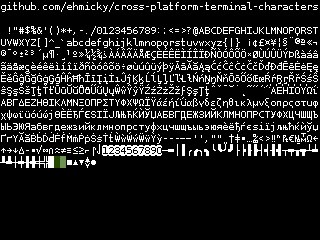

In [254]:
core_support = (''' !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`'''
                '''abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬®¯°±²³´µ¶·¸¹º»¼½¾¿'''
                '''ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ'''
                '''ĀāĂăĄąĆćĈĉĊċČčĎďĐđĒēĖėĘęĚěĜĝĞğĠġĢģĤĥĦħĪīĮįİıĴĵĶķĹĺĻļĽľŁłŃńŅņŇňŌōŐőŒœ'''
                '''ŔŕŖŗŘřŚśŜŝŞşŠšŢţŤťŪūŬŭŮůŰűŲųŴŵŶŷŸŹźŻżŽžƒȘșȚțˆˇˉ˘˙˛˜˝΄΅ΆΈΉΊΌΎΏΐΑΒΓΔΕΖΗ'''
                '''ΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩΪΫάέήίΰαβγδεζηθικλμνξοπρςστυφχψωϊϋόύώϳϴЀЁЂЃЄЅІЇЈЉЊЋЌЍЎЏ'''
                '''АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяѐёђѓєѕіїј'''
                '''љњћќѝўџҐґҮӐӑḂḃḊḋḞḟṀṁṖṗṠṡṪṫẀẁẂẃẄẅỲỳ‐‒–—―‘’‚“”„†‡•…‰‹›‼ⁿ₧€№™Ω←↑→↓∆−∙√∞∩≈≠≡≤≥⌐⌠⌡'''
                '''①②③④⑤⑥⑦⑧⑨⓪─━│┃┌┏┐┓└┗┘┛├┝┠┣┤┥┨┫┬┯┰┳┴┷┸┻┼┿╂╋╪╬█░▒■▲▼◊●''')
s=reset
s+='github.com/ehmicky/cross-platform-terminal-characters\n\n'
s+=core_support
print2(s)
time.sleep(pauseaftershow)
#save_snapshot('cross-platorm')

In [ ]:
print2(reset+\
       "Legacy Computing Characters (some custom additions):\n\n"+\
('\n'+' '*10+"🭵🮀🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮁🮀🮼"+\
'\n'+' '*10+"🭵                          🮸"+\
'\n'+' '*10+"🭵     🮲🮳 🯅 🯆 🯇 🯈 🯉         |  {"+sty.ef.inverse+'ok'+sty.rs.inverse+'}'+\
'\n'+' '*10+"🭵                          |"+\
'\n'+' '*10+"🭵  🯁🯂🯃 🮹🮺     🯰🯱 🯲🯳🯴🯵🯶🯷🯸🯹  .     🮰"+\
'\n'+' '*10+"🭵                          |"+\
'\n'+' '*10+"🭵🮵===========$============🮶🮷"+\
'\n'+' '*10+
'\n'+' '*10+"   🯀 🯄 🮻 🮽 🮾 🮿 🮱 🮴 🮯 "+\
'\n'+' '*10+
'\n'+' '*10+"   🮌 🮍 🮎 🮏 🮐 🮑 🮒 \U0001fb93 🮔 🮕 "+\
'\n'+' '*10+
'\n'+' '*10+"   🮖 🮗 🮘 🮙 🮚 🮛 🮜 🮝 🮞 🮟 "
)
# Add ons: 
.replace('=','\U0001fbcb') # Empty horizontal scroll bar
.replace('$','\U0001fbcc') # Horizontal scroll handle
.replace('.','\U0001fbcd') # Vertical scroll handle
.replace('|','\U0001fbce') # Empty vertical scroll bar
.replace('{','\U0001fbcf') # Left round button end
.replace('}','\U0001fbd0') # Right round button end
)
time.sleep(pauseaftershow)
#save_snapshot('legacy')

[|||||||||||||||||||||||||||||            ]

In [ ]:

print2(sty.rs.all + clearscreen + hidecursor)
print2(goto(9,55//2-21)+fg(255,100,0)+'◖'+sty.ef.inverse+' github.com/michaelerule/ILI9341TTY  '+sty.rs.inverse+'◗')
time.sleep(1)

print2(goto(14,55//2-19)+fg(255,100,0)+' (sorry about the cracked screen)')

# Inspect mapped unicode blocks

In [ ]:
import sys
sys.path.append('../prepare_fonts/')
from font_utilities import get_unicode_blocks_information
from CONFIG import *
toprint = mapped_blocks + softmapped
for b,(name,start,stop,N) in get_unicode_blocks_information().items(): 
    if b in mapped_blocks:
        s = reset+name+'\n'
        for i in range(start,stop+1):
            c = chr(i)
            if exists(c): s += c
        print2(s,delay=0)
        print(s)
        input("Press any key to continue...")

# Screen capture all mapped unicode blocks to see how characters render, and which are missing

In [229]:

'''
RGB = printscreen()
figure(figsize=(320,240),dpi=1)
imshow(RGB,interpolation='nearest')
axis('off')
subplots_adjust(0,0,1,1,0,0)
'''

import sys
sys.path.append('../prepare_fonts/')
from font_utilities import get_unicode_blocks_information
from CONFIG import *
toprint = mapped_blocks + softmapped
groups = []
TERMCOLS = 48
K = TERMROWS*TERMCOLS
s = ''
j = 0
actual_groups = []
actual_s = ''
# Skip unsupported combining characters
exclude = [0x483,0x484,0x485,0x486,0x487,0x488,0x489,0x903,0x093B,0x093E,0x093F,0x940,0x949,0x94A,0x94B,0x94C,
          0x94D,0x94E,0x94F,0x963] + [*range(0xa66f,0xa67f+1)]+[0xa69e,0xa69f,0xfb1e]
# Some of the armenian characters are implemented as combining
include = [0x55C,0x55D,0x55E]
for b,(name,start,stop,N) in get_unicode_blocks_information().items(): 
    if b=='halfwidthandfullwidthforms': continue
    if b in toprint:
        for i in range(start,stop+1):
            c =  chr(i)
            actual_s += c
            if c<' ' or (c>'~' and c<'¡'):
                c = ' '
            if i in include or (
                not i in exclude and unicodedata.category(c)[0]=='M'):
                c = ' '+c
            s += c
            j += 1
            if (j>=K):
                j = 0
                groups += [s]
                actual_groups += [actual_s]
                s = ''
                actual_s = ''
            elif (j%TERMCOLS==0):
                s += '\n'
groups += [s]
actual_groups += [actual_s]

bitmaps = []
for i,group in enumerate(groups):
    print('Group %d'%i)
    print(group)
    print2(reset+group,delay=0.001)
    RGB = printscreen()
    bitmaps += [RGB]
    figure(figsize=(320,240),dpi=1)
    imshow(RGB,interpolation='nearest')
    axis('off')
    subplots_adjust(0,0,1,1,0,0)
    show()

Group 0
                                 !"#$%&'()*+,-./
0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_
`abcdefghijklmnopqrstuvwxyz{|}~                 
                 ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿
ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîï
ðñòóôõö÷øùúûüýþÿĀāĂăĄąĆćĈĉĊċČčĎďĐđĒēĔĕĖėĘęĚěĜĝĞğ
ĠġĢģĤĥĦħĨĩĪīĬĭĮįİıĲĳĴĵĶķĸĹĺĻļĽľĿŀŁłŃńŅņŇňŉŊŋŌōŎŏ
ŐőŒœŔŕŖŗŘřŚśŜŝŞşŠšŢţŤťŦŧŨũŪūŬŭŮůŰűŲųŴŵŶŷŸŹźŻżŽžſ
ƀƁƂƃƄƅƆƇƈƉƊƋƌƍƎƏƐƑƒƓƔƕƖƗƘƙƚƛƜƝƞƟƠơƢƣƤƥƦƧƨƩƪƫƬƭƮƯ
ưƱƲƳƴƵƶƷƸƹƺƻƼƽƾƿǀǁǂǃǄǅǆǇǈǉǊǋǌǍǎǏǐǑǒǓǔǕǖǗǘǙǚǛǜǝǞǟ
ǠǡǢǣǤǥǦǧǨǩǪǫǬǭǮǯǰǱǲǳǴǵǶǷǸǹǺǻǼǽǾǿȀȁȂȃȄȅȆȇȈȉȊȋȌȍȎȏ
ȐȑȒȓȔȕȖȗȘșȚțȜȝȞȟȠȡȢȣȤȥȦȧȨȩȪȫȬȭȮȯȰȱȲȳȴȵȶȷȸȹȺȻȼȽȾȿ
ɀɁɂɃɄɅɆɇɈɉɊɋɌɍɎɏɐɑɒɓɔɕɖɗɘəɚɛɜɝɞɟɠɡɢɣɤɥɦɧɨɩɪɫɬɭɮɯ
ɰɱɲɳɴɵɶɷɸɹɺɻɼɽɾɿʀʁʂʃʄʅʆʇʈʉʊʋʌʍʎʏʐʑʒʓʔʕʖʗʘʙʚʛʜʝʞʟ
ʠʡʢʣʤʥʦʧʨʩʪʫʬʭʮʯʰʱʲʳʴʵʶʷʸʹʺʻʼʽʾʿˀˁ˂˃˄˅ˆˇˈˉˊˋˌˍˎˏ
ːˑ˒˓˔˕˖˗˘˙˚˛˜˝˞˟ˠˡˢˣˤ˥˦˧˨˩˪˫ˬ˭ˮ˯˰˱˲˳˴˵˶˷˸˹˺˻˼˽˾˿
 ̀ ́ ̂ ̃ ̄ ̅ ̆ ̇ ̈ ̉ ̊ ̋ ̌ ̍ ̎ ̏ ̐ ̑ ̒ ̓ ̔ ̕ ̖ ̗ ̘ ̙ ̚ ̛ ̜ ̝ ̞ ̟ ̠ ̡ ̢ ̣ ̤ ̥ ̦ ̧ ̨ ̩ ̪ ̫ ̬ ̭ ̮ ̯
 ̰ ̱ ̲ ̳ ̴ ̵ ̶ ̷ ̸ ̹ ̺ ̻ ̼ ̽ ̾ ̿ ̀ ́ ͂ ̓ ̈́ ͅ ͆ ͇ ͈ ͉ ͊ ͋ ͌ ͍ ͎ ͏ ͐ ͑ ͒ ͓ ͔ ͕ ͖ ͗ ͘ ͙ ͚ ͛ ͜ ͝ ͞ ͟
 ͠ ͡ ͢ ͣ ͤ ͥ ͦ

KeyboardInterrupt: 

# Show all supported characters

In [44]:
allc = ''
allb = []
for g,b in zip(actual_groups,bitmaps):
    q = b[:,:48*6,:].reshape(20,12,48,6,3)
    q = q.transpose(0,2,1,3,4)
    q = q.reshape(20*48,12,6,3)
    keep = [(g[i],q[i]) for i in range(K) if not all(q[i]==0) and not g[i]==' ' and g[i]<='🯹']
    kg,kb = zip(*keep)
    allc += ''.join(kg)
    allb += kb

nc = 96
nr = int(ceil(len(allc)/nc))
nn = nr*nc
allc = allc.ljust(nn)
allb += [uint8(zeros((12,6,3))) for i in range(nn-shape(allb)[0])]
allb = array(allb).reshape(nr,nc,12,6,3)
allc = np.array([*allc]).reshape(nr,nc)
q = array([q.transpose(0,2,1,3).reshape(nc*6,12,3).transpose(1,0,2) for q in allb])
q = q.reshape(nr*12,nc*6,3)
imh,imw = q.shape[:2]
figure(figsize=(imw,imh),dpi=1)
imshow(q,interpolation='nearest')
axis('off')
subplots_adjust(0,0,1,1,0,0)
savefig('supported.png')

supported = '\n'.join(''.join(r) for r in allc)
to_replace = ''
for c in supported: 
    if unicodedata.category(c)[0]=='M':
        to_replace += c
for c in to_replace:
    supported = supported.replace(c,' '+c)
print(supported)

## Devanagari diacritics prooved too difficult!

One would need to add custom code to handld prefix diacritic. 

```python
s  = reset + 'Devanagari\n'
s += ('ऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणत'
      'थदधनऩपफबभमयरऱलळऴवशषसहॐक़ख़ग़ज़ड़ढ़फ़य़ॠॡॱ'
      'ॲॳॴॵॶॷॸॹॺॻॼॾॿॽ।॥०१२३४५६७८९॰')

base = ('अआइउऊऋऌएकखगघङचछजझञटठडढणत'
      'थदधनपफबभमयरऱलळवशषसहॐॠॡॱ'
      'ॲॳॴॵॸॹॺॻॼॾॿ')
modifier = ('\u0900\u0901\u0902\u093A\u093B\u093C\u093E\u093F'
            '\u0940\u0941\u0942\u0943\u0944\u0945\u0946\u0947\u0948'
            '\u0949\u094A\u094B\u094C\u094E\u094F\u0951\u0952'
            '\u0953\u0954\u0955\u0956\u0957')

print2(reset)
for i,b in enumerate(base):
    print2(b+' ')
    print(b+' ',end='')
    for m in modifier:
        print(b+m,end='')
        print2(b+m)
    print()
    print2('\n')
    if (i==18): break
    
for i in range(0x0900,1+ord('ॿ')):
n = unicodedata.name(chr(i))
if 'SIGN' in n or 'ACCENT' in n:
    print('0x%X  %s %s'%(i,chr(i),n))

        
print('कखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसह़কখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়'
      'ৰৱਕਖਗਘਙਚਛਜਝਞਟਠਡਢਣਤਥਦਧਨਪਫਬਭਮਯਰਲਵਸਹ਼કખગઘઙચછજઝઞટઠડઢણતથદધનપફબભમયરલ'
      'ળવશષસહକଖଗଘଙଚଛଜଝଞଟଠଡଢଣତଥଦଧନପଫବଭମଯରଲଳଶଷସହୟୱகஙசஜஞடணதநனபமய'
      'ரறலளழவஶஷஸஹకఖగఘఙచఛజఝఞటఠడఢణతథదధనపఫబభమయరఱలళవశషసహಕಖಗಘಙಚಛಜಝ'
      'ಞಟಠಡಢಣತಥದಧನಪಫಬಭಮಯರಱಲಳವಶಷಸಹೞകഖഗഘങചഛജഝഞടഠഡഢണതഥദധനഩപഫബ'
      'ഭമയരറലളഴവശഷസഹකඛගඝඞචඡජඣඤටඨඩඪණතථදධනපඵබභමයරලවශෂසහළกขฃคฅฆงจฉ'
      'ชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬฮກຂຄຆງຈຉຊຌຍຎຏຐຑຒຓຕຖທຘນປຜພຠມຣລວຨຩສຫຬཀ'
      'ཁགངཅཆཇཉཊཋཌཎཏཐདནཔཕབམཛཝཡརལཤཥསཧྷကခဂဃငစဆဇဈဉညဋဌဍဎဏတထဒဓနပဖဗဘမယ'
      'ရလဝသဟဠၐၑᜃᜄᜅᜆᜇᜈᜉᜊᜋᜌᜎᜏᜐᜑᜣᜤᜥᜦᜧᜨᜩᜪᜫᜬᜭᜮᜯᜰᜱᝃᝄᝅᝆᝇᝈᝉᝊᝋᝌᝍᝎᝏᝐᝑᝣᝤ'
      'ᝥᝦᝧᝨᝩᝪᝫᝬᝮᝯᝰកខគឃងចឆជឈញដឋឌឍណតថទធនបផពភមយរលវឝឞសហឡᤁ'
      'ᤂᤃᤄᤅᤆᤇᤈᤉᤊᤋᤌᤍᤎᤏᤐᤑᤒᤓᤔᤕᤖᤗᤘᤙᤚᤛᤜᨀᨁᨂᨄᨅᨆᨈᨉᨊᨌᨍᨎᨐᨑᨒᨓᨔᨕᬓᬔᬕᬖᬗ'
      'ᬘᬙᬚᬛᬜᬝᬞᬟᬠᬡᬢᬣᬤᬥᬦᬧᬨᬩᬪᬫᬬᬭᬮᬯᬰᬱᬲᬳᮊᮌᮍᮎᮏᮑᮒᮓᮔᮕᮘᮙᮚᮛᮜᮝ'
      'ᮞᮠᮮᮯᮽᯂᯅᯇᯉᯎᯐᯑᯒᯔᯖᯘᯛᯝᯞᯠᰀᰂᰃᰅᰆᰇᰈᰉᰊᰋᰌᰍᰎᰐᰓᰕᰚᰛᰜᰝᰟᰠᰡ᰷ᱍᱎᱏḍḷḻṅ'
      'ṇṉṟṣṭẏ  ꠇꠈꠉꠊꠌꠍꠎꠏꠐꠑꠒꠓꠔꠕꠖꠗꠘꠙꠚꠛꠜꠝꠞꠟꠡꠢꤰꤱꤲꤳꤴꤵꤶꤷꤸꤹꤺꤻꤼꤽꤾꤿꥀꥁꦏꦑꦒꦓꦔ'
      'ꦕꦖꦗꦘꦙꦚꦛꦜꦝꦞꦟꦠꦡꦢꦣꦤꦥꦦꦧꦨꦩꦪꦫꦭꦮꦯꦰꦱꦲꨆꨇꨈꨉꨋꨌꨍ'
      'ꨎꨏꨑꨓꨔꨕꨖꨘꨚꨜꨝꨞꨠꨢꨣꨤꨥꨦꨧꨨꫢꫣꫤꫥꫦꫧꫨꫩꫪꯀꯁꯂꯃꯄꯅꯆꯇꯈꯉꯊꯋ'
      'ꯌꯍꯐꯒꯓꯔꯕꯖꯗꯘꯙꯚ𑀓𑀔𑀕𑀖𑀗𑀘𑀙𑀚𑀛𑀜𑀝𑀞𑀟𑀠𑀡𑀢𑀣𑀤𑀥𑀦𑀧𑀨𑀩𑀪𑀫𑀬𑀭𑀮𑀯𑀰𑀱𑀲𑀳𑀴𑂍𑂎𑂏𑂐𑂑𑂒𑂓𑂔𑂕𑂖𑂗𑂘𑂙𑂛'
      '𑂝𑂞𑂟𑂠𑂡𑂢𑂣𑂤𑂥𑂦𑂧𑂨𑂩𑂪𑂫𑂬𑂭𑂮𑂯𑄇𑄈𑄉𑄊𑄋𑄌𑄍𑄎𑄏𑄐𑄑𑄒𑄓𑄔𑄕𑄖𑄗𑄘𑄙𑄚𑄛𑄜𑄝𑄞𑄟𑄠𑄡𑄢𑄣𑄤𑄥𑄦𑅄𑌕'
      '𑌖𑌗𑌘𑌙𑌚𑌛𑌜𑌝𑌞𑌟𑌠𑌡𑌢𑌣𑌤𑌥𑌦𑌧𑌨𑌪𑌫𑌬𑌭𑌮𑌯𑌰𑌲𑌳𑌵𑌶𑌷𑌸𑌹𑒏𑒐𑒑'
      '𑒒𑒓𑒔𑒕𑒖𑒗𑒘𑒙𑒚𑒛𑒜𑒝𑒞𑒟𑒠𑒡𑒢𑒣𑒤𑒥𑒦𑒧𑒨𑒩𑒪𑒬𑒭𑒮𑒯𑻠𑻡𑻢𑻣𑻤𑻥𑻦𑻧𑻨𑻩𑻪𑻫𑻬𑻭𑻮𑻯𑻰𑻱')

missing_georgian = ('ႠႡႢႣႤႥႦႧႨႩႪႫႬႭႮႯႰႱႲႳႴႵႶႷႸႹႺႻႼႽႾႿჀჁჂჃჄჅ'
                    'ჇჍᲐᲑᲒᲓᲔᲕᲖᲗᲘᲙᲚᲛᲜᲝᲞᲟᲠᲡᲢᲣᲤᲥᲦᲧᲨᲩᲪᲫᲬᲭᲮᲯᲰᲱᲲᲳᲴᲵᲶᲷᲸᲹᲺᲽᲾᲿ'
                    'ⴀⴁⴂⴃⴄⴅⴆⴇⴈⴉⴊⴋⴌⴍⴎⴏⴐⴑⴒⴓⴔⴕⴖⴗⴘⴙⴚⴛⴜⴝⴞⴟⴠⴡⴢⴣⴤⴥ'
                    'ⴧⴭ𐔰𐔱𐔲𐔳𐔴𐔵𐔶𐔷𐔸𐔹𐔺𐔻𐔼𐔽𐔾𐔿𐕀𐕁𐕂𐕃𐕄𐕅𐕆𐕇𐕈𐕉𐕊𐕋𐕌𐕍𐕎𐕏𐕐𐕑𐕒𐕓𐕔𐕕𐕖𐕗𐕘𐕙𐕚𐕛𐕜𐕝𐕞𐕟𐕠𐕡𐕢𐕣')
```